In [1]:
import pandas as pd
from tabulate import tabulate
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import math
import numpy as np
import statistics 
import datetime
import json 
from random import randint
from copy import copy

list_categories_str = [ "contribution", "strengths", "weakness", "reproducibility", "detailed", "justification" ]

In [2]:
########################################################################
# Statistics regarding the number of words 
# (in total and for each category of the review separately)
########################################################################

# Set the year and output directory
year_ = "2023"
output_directory = Path(f"../miccai{year_}") 

# Define the CSV directory and path for word count data
csv_directory = output_directory / "extract-csv"
path_words_count = csv_directory / 'count_words.csv'

# Read the word count data into a DataFrame
df_words = pd.read_csv(path_words_count, sep="\t", header=[0, 1], index_col=[0, 1], skip_blank_lines=True)

# Initialize a DataFrame for word count statistics
df_stats_word_counts = pd.DataFrame(columns=["category", "mean", "max", "min", "median", "std", "iqr"])
df_stats_word_counts.set_index(["category"], inplace=True)

# Calculate word count statistics for each category and overall
for category in list_categories_str + ["total"]:
    list_words = df_words.loc[:, (category, "review 1")].values.tolist() + df_words.loc[:, (category, "review 2")].values.tolist() + df_words.loc[:, (category, "review 3")].values.tolist()
    newlist = [x for x in list_words if math.isnan(x) == False]
    df_stats_word_counts.loc[(category), "mean"] = np.mean(newlist)
    df_stats_word_counts.loc[(category), "median"] = np.median(newlist)
    df_stats_word_counts.loc[(category), "max"] = max(newlist)
    df_stats_word_counts.loc[(category), "min"] = min(newlist)
    df_stats_word_counts.loc[(category), "std"] = np.std(newlist)
    df_stats_word_counts.loc[(category), "iqr"] = scipy.stats.iqr(newlist)
    
    # Calculate deciles for the distribution
    deciles_ = statistics.quantiles(newlist, n=10, method='inclusive')
    for i in range(9):
        df_stats_word_counts.loc[(category), f"{(i + 1) * 10}th centile"] = deciles_[i]

# Print and save the word count statistics
print(f"Statistics regarding the number of words")
print(f"(in total and for each category of the review separately)")
print(tabulate(df_stats_word_counts, headers='keys', tablefmt='psql', floatfmt=".2f"))
stats_directory = output_directory / "stats"
if not stats_directory.is_dir():
    os.mkdir(stats_directory)

output_path = os.path.join(stats_directory, f'stats_word_counts.csv')
print(f"Outputting result in {output_path}")
df_stats_word_counts.to_csv(output_path, index=True, sep="\t", encoding='utf-8')


Statistics regarding the number of words
(in total and for each category of the review separately)
+-----------------+--------+---------+-------+----------+--------+--------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
| category        |   mean |     max |   min |   median |    std |    iqr |   10th centile |   20th centile |   30th centile |   40th centile |   50th centile |   60th centile |   70th centile |   80th centile |   90th centile |
|-----------------+--------+---------+-------+----------+--------+--------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------|
| contribution    |  60.90 |  167.00 |  0.00 |    56.00 |  30.56 |  42.00 |          26.00 |          34.00 |          42.00 |          49.00 |          56.00 |          63.00 |          74.00 |          85.00 |   

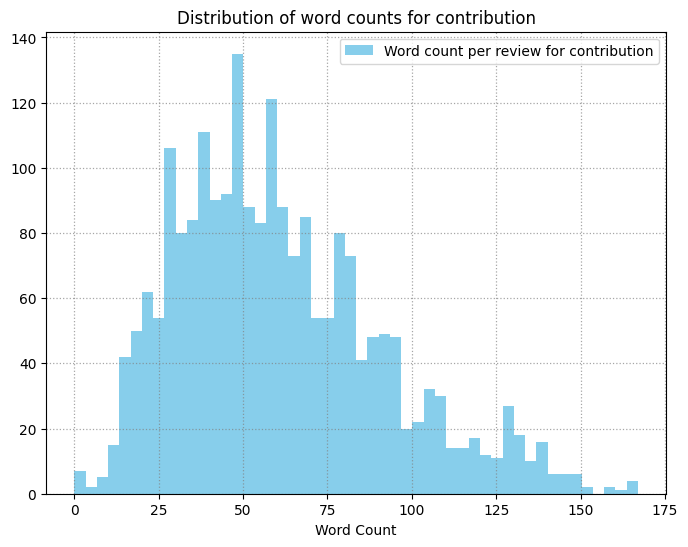

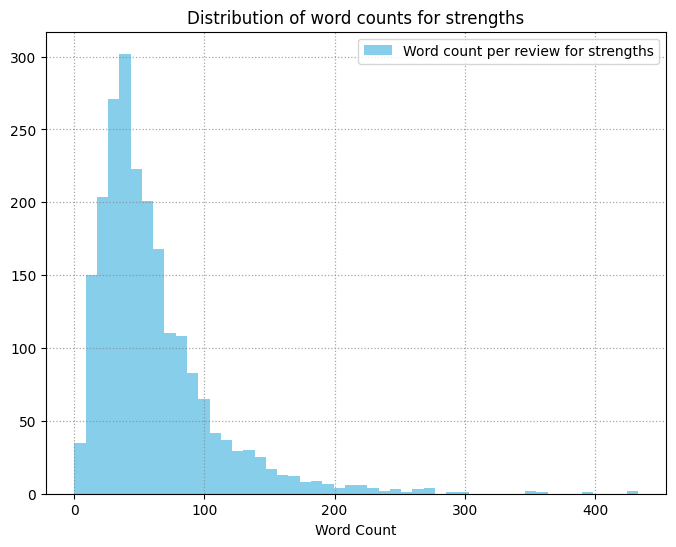

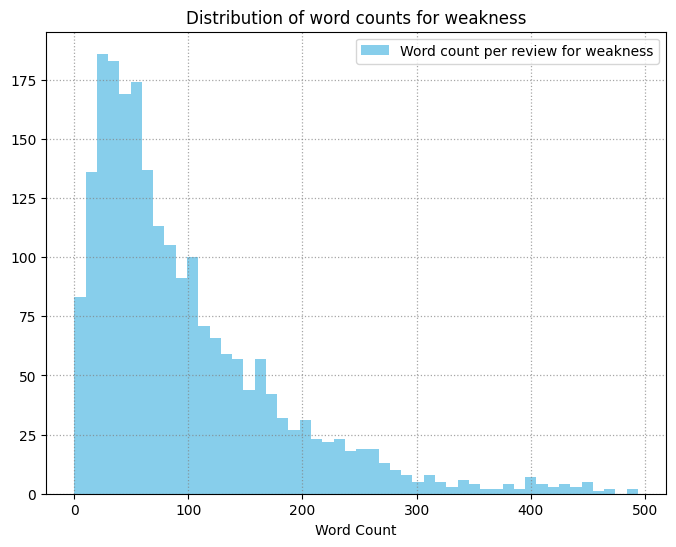

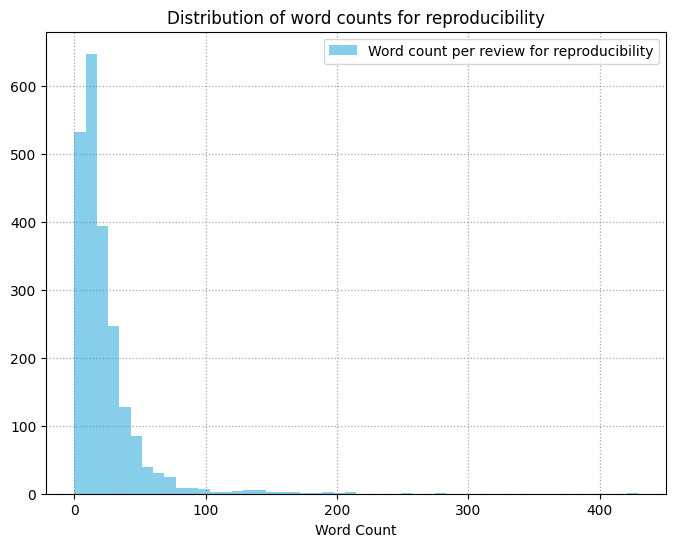

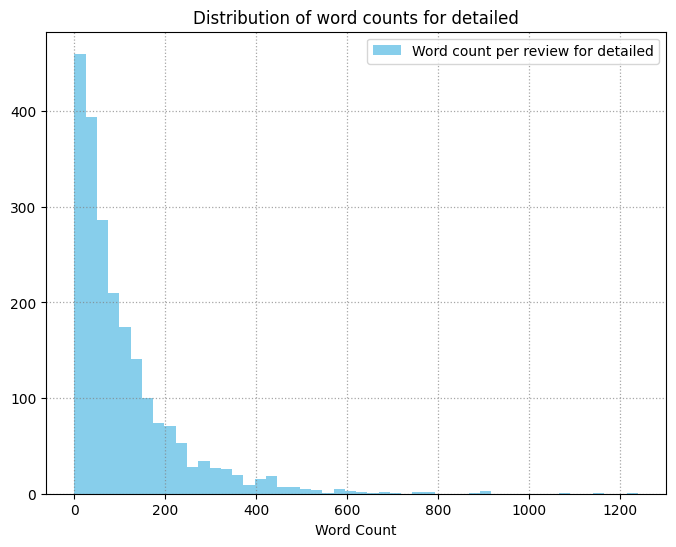

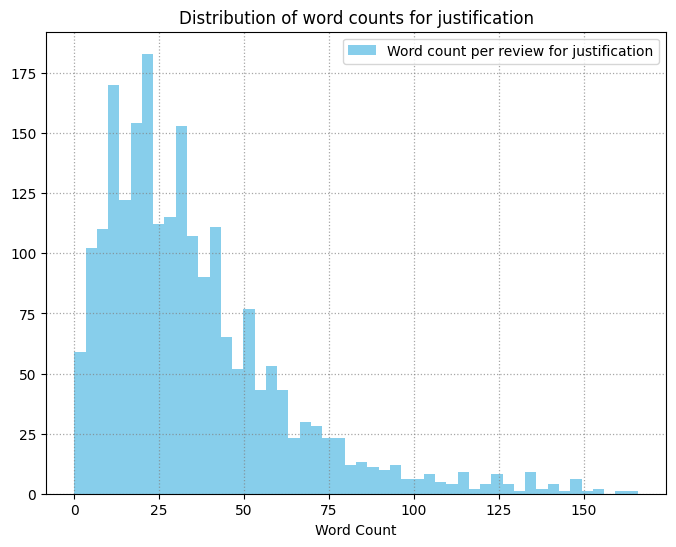

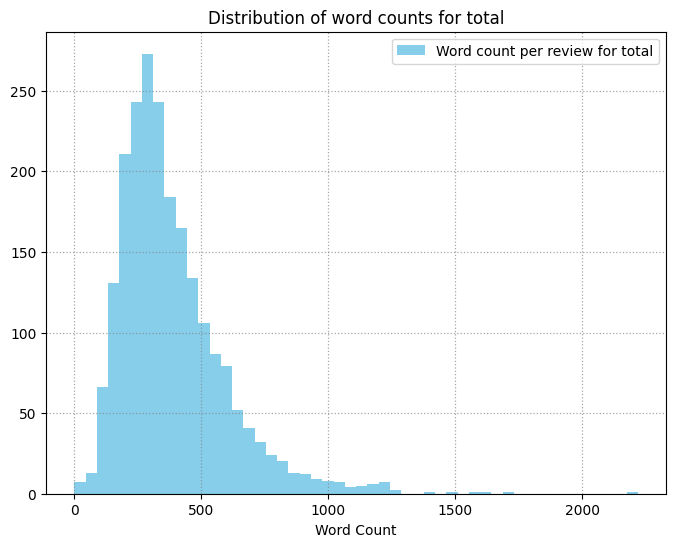

In [3]:
histo_path = Path(output_directory) / "histo"
if not histo_path.is_dir():
    os.mkdir(histo_path)

for category in list_categories_str + ["total"] :

    list = df_words.loc[:,(category, "review 1")].values.tolist() + df_words.loc[:,(category, "review 2")].values.tolist() + df_words.loc[:,(category, "review 3")].values.tolist()

    plt.figure(figsize=(8, 6))
    plt.hist(list, bins=50, color='skyblue', label=f"Word count per review for {category}")

    plt.title(f'Distribution of word counts for {category}')
    plt.xlabel('Word Count')
    plt.ylabel('')
    plt.legend()
    plt.grid(True,color='grey', linestyle=':', linewidth=0.9, alpha=0.7)
    plt.savefig(os.path.join(histo_path, f"{category}_hist_count_words.pdf"))

In [4]:
##############################################################################
# count of reviews containing the word "check-list," "checklist," or "check list"
##############################################################################

# Define the path to the CSV file containing reproducibility checklist reviews
path_repro_check = csv_directory / "reproducibility_checklist_reviews.csv"

# Read the DataFrame from the CSV file
df_check = pd.read_csv(path_repro_check, sep="\t", index_col=["id", "title"], skip_blank_lines=True)

# Initialize a variable to count the total number of reviews mentioning the checklist
total_check = 0

# Iterate through the DataFrame to count the occurrences of checklist mentions
for id, id_df in df_check.groupby(level=0):
    for _, title in id_df.index.values:
        for i in range(1, 4):
            # Get the content of the review
            x = df_check.loc[(id, title), f"review {i}"]
            
            # Check if the content is not NaN (not missing)
            if not pd.isna(x):
                total_check += 1

# Print the total count of reviews containing the word "check-list," "checklist," or "check list"
print(f"We can count {total_check} reviews from {len(df_check)} different papers that contain the word check-list, or checklist, or check list.")


We can count 81 reviews from 78 different papers that contain the word check-list, or checklist, or check list.


In [5]:
# Extract the lengths of the reproducibility part and the total review for all reviews
repro_list = (
    df_words.loc[:, ("reproducibility", "review 1")].values.tolist() +
    df_words.loc[:, ("reproducibility", "review 2")].values.tolist() +
    df_words.loc[:, ("reproducibility", "review 3")].values.tolist()
)
total_list = (
    df_words.loc[:, ("total", "review 1")].values.tolist() +
    df_words.loc[:, ("total", "review 2")].values.tolist() +
    df_words.loc[:, ("total", "review 3")].values.tolist()
)

# Calculate Pearson and Spearman correlations between the lengths
pearson_corr = scipy.stats.pearsonr(repro_list, total_list)
spearman_corr = scipy.stats.spearmanr(repro_list, total_list)

# Print the correlation results
print(f"Correlation between the length of the total review and the length of the reproducibility part (computed on {len(repro_list)} reviews):")
print(f"Pearson's correlation: rho={round(pearson_corr.statistic, 2)}, p={pearson_corr.pvalue}")
print(f"Spearman's correlation: r={round(spearman_corr.statistic, 2)}, p={spearman_corr.pvalue}")


Correlation between the length of the total review and the length of the reproducibility part (computed on 2190 reviews):
Pearson's correlation: rho=0.47, p=3.8686946577453113e-119
Spearman's correlation: r=0.45, p=6.95538100703878e-109


In [6]:
##############################################################################
# Calcul percentiles
##############################################################################

# Specify the category for which to analyze the word count
category = "reproducibility"

# Load the reviews and word count data
path_reviews = csv_directory / "reviews.csv"
df_reviews = pd.read_csv(path_reviews, sep="\t", header=[0, 1], index_col=[0, 1], skip_blank_lines=True)

# Create a new DataFrame to store paper_id, word count, review text, and review number
df_ = pd.DataFrame(columns=["paper_id", "nb_words", "review", "nb_review"])

# Iterate through the grouped DataFrame by paper_id and title to collect relevant data
for id, id_df in df_words.groupby(level=0):
    for _, title in id_df.index.values:
        for i in range(1, 4):
            # Create a row with paper_id, word count, review text, and review number
            row = [id] + [df_words.loc[(id, title), (category, f"review {i}")]] + [df_reviews.loc[(id, title), (category, f"review {i}")]] + [i]
            row_df = pd.DataFrame([row], columns=["paper_id", "nb_words", "review", "nb_review"])
            # Concatenate the row to the main DataFrame
            df_ = pd.concat([df_, row_df])

# Sort the DataFrame based on word count
df_.sort_values("nb_words", inplace=True)

# Calculate deciles for the word count distribution
list_nb_words = df_.loc[:, "nb_words"].values.tolist()
deciles_ = statistics.quantiles(list_nb_words, n=100)

# Set the index of the DataFrame for further analysis
df_.set_index(["paper_id", "nb_review"], inplace=True)


In [7]:
##############################################################################
# Display random review between the 40th and 60th percentiles (number of words)
##############################################################################

# Set the number of random reviews to be selected
nb_reviews = 10

# Get the lower and upper bounds for the 0th and 30th percentiles
lower_bound_40th = deciles_[40]
upper_bound_60th = deciles_[60]

# Print a separator line for clarity
print("*" * 100)
# Display information about the selected range of percentiles
print(f"{nb_reviews} random reviews between {40} ({lower_bound_40th:.0f} words) and {60} ({upper_bound_60th:.0f} words) percentiles")
print("*" * 100)
print()

# Create a copy of the original DataFrame for manipulation
df_copy = copy(df_)

# Iterate through the DataFrame to filter out reviews outside the specified word count range
for id, id_df in df_copy.groupby(level=0):
    for _, review in id_df.index.values:
        x = float(df_copy.loc[(id, review), "nb_words"])
        if x <= lower_bound_40th or x >= upper_bound_60th:
            df_copy.drop((id, review), inplace=True)

# Reset the index of the modified DataFrame
df_copy.reset_index(inplace=True)

# Display random reviews within the specified word count range
for i in range(nb_reviews):
    # Generate a random index to select a review from the DataFrame
    nb = randint(1, len(df_copy))
    # Print the selected review and its word count
    print(f"Review: {df_copy.loc[nb, 'review']}")
    print(f"Word Count: {df_copy.loc[nb, 'nb_words']}")
    print("-" * 50)


****************************************************************************************************
10 random reviews between 40 (13 words) and 60 (20 words) percentiles
****************************************************************************************************

Review: This study is not based on public dataset. The code is not open to public either.
Word Count: 16
--------------------------------------------------
Review: The authors intend to release the code and the implementations details are provided. The results should be reproducible.
Word Count: 18
--------------------------------------------------
Review: The model parameters and experimental settings are provided. Code will be released. Dataset will be available on request.
Word Count: 18
--------------------------------------------------
Review: The datasets used are publicly available. The function parameters are explained adequately ensuring reproducibility of the work.
Word Count: 17
----------------------------

In [8]:
##############################################################################
# Display random review between the 0th and 30th percentiles (number of words)
##############################################################################

# Set the number of random reviews to be selected
nb_reviews = 10

# Get the lower and upper bounds for the 0th and 30th percentiles
lower_bound_00th = deciles_[0]
upper_bound_30th = deciles_[30]

# Print a separator line for clarity
print("*" * 100)
# Display information about the selected range of percentiles
print(f"{nb_reviews} random reviews between {0} ({lower_bound_00th:.0f} words) and {30} ({upper_bound_30th:.0f} words) percentiles")
print("*" * 100)
print()

# Create a copy of the original DataFrame for manipulation
df_copy = copy(df_)

# Iterate through the DataFrame to filter out reviews outside the specified word count range
for id, id_df in df_copy.groupby(level=0):
    for _, review in id_df.index.values:
        x = float(df_copy.loc[(id, review), "nb_words"])
        if x <= lower_bound_00th or x >= upper_bound_30th:
            df_copy.drop((id, review), inplace=True)

# Reset the index of the modified DataFrame
df_copy.reset_index(inplace=True)

# Display random reviews within the specified word count range
for i in range(nb_reviews):
    # Generate a random index to select a review from the DataFrame
    nb = randint(1, len(df_copy))
    # Print the selected review and its word count
    print(f"Review: {df_copy.loc[nb, 'review']}")
    print(f"Word Count: {df_copy.loc[nb, 'nb_words']}")
    print("-" * 50)


****************************************************************************************************
10 random reviews between 0 (1 words) and 30 (11 words) percentiles
****************************************************************************************************

Review: The authors are providing code so this should be reproducible.
Word Count: 10
--------------------------------------------------
Review: code was provided
Word Count: 3
--------------------------------------------------
Review: Reproducible, code is provided.
Word Count: 4
--------------------------------------------------
Review: The reproducibility is good given the released codes.
Word Count: 8
--------------------------------------------------
Review: The paper is reproducible.
Word Count: 4
--------------------------------------------------
Review: I think it can be easily reproduced.
Word Count: 7
--------------------------------------------------
Review: Not applicable
Word Count: 2
----------------------

In [9]:
# Create a dictionary to store metadata about the word count data
data = {
    "nb_papers": len(df_words),
    "nb_reviews": len(df_words) * 3,
    "date": str(datetime.date.today()),
    "time": str(datetime.datetime.utcnow()),
    "data_path": str(path_words_count)
}

# Convert the dictionary to JSON format with indentation for readability
json_data = json.dumps(data, skipkeys=True, indent=4)

# Set the path for the JSON file containing metadata
json_path = stats_directory / "data.json"

# Write the JSON data to the specified file
with open(json_path, "w") as f:
    f.write(json_data)
